In [73]:
import pandas as pd 
import wandb
from typing import Any
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
import matplotlib

In [88]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


def width_legend_on_side(ax, shrink: float = 0.85):
    # Shrink current axis by X%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * shrink, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title="Width")



In [169]:

api = wandb.Api(api_key="0397e0196c2ed27234ec92d433cbe73fcfc72db1")


def parse_date_str(date_str: str) -> Union[datetime, None]:
    return datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")


# Project is specified by <entity/project-name>
runs = api.runs("tensor-programs-v-reproduction/tensor-reprogram", filters={"State": "finished"})

summary_list, config_list, name_list, created_at_list, finished_at_list = [], [], [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    # .created_at and .finished_at are timestamps of when the run was created and finished.
    created_at_list.append(parse_date_str(run.created_at))
    finished_at_list.append(parse_date_str(run.finished_at) if hasattr(run, "finished_at") else None)

runs_df_nested = pd.DataFrame(
    {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "created_at": created_at_list,
        "finished_at": finished_at_list,
    }
)

runs_df_nested.to_csv("project.csv")


In [170]:
def flatten_dict(d: dict[str, Any], parent_key: str = '', sep: str = '.'):
    """
    A recursive function to flatten a nested dictionary into a single-level dictionary.

    Example:
        >>> flatten_dict({'a': 1, 'b': {'c': 2, 'd': 3}}, parent_key='parentkey', sep='|')
        {'parentkey|a': 1, 'parentkey|b|c': 2, 'parentkey|b|d': 3}
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def flatten_dataframe(df: pd.DataFrame, columns: list[str]):
    """
    A function to flatten the nested dictionaries in the given dataframe.

    Args:
        df: The dataframe to flatten.
        columns: The columns with dictionary entries to flatten.
    """
    flat_data = []
    for i, row in df.iterrows():
        # Preserve the non-dictionary columns
        non_dict_cols = {col: row[col] for col in df.columns if col not in columns}
        # Flatten the specified dictionary columns
        dict_cols = {}
        for col in columns:
            dict_cols.update(flatten_dict(row[col], parent_key=col, sep='.'))
        # Combine the non-dictionary and dictionary columns and add the row name
        flat_data.append({'name': row['name'], **non_dict_cols, **dict_cols})

    return pd.DataFrame(flat_data)


In [171]:
runs_df = flatten_dataframe(runs_df_nested, columns=['config', 'summary'])

# MLP Experiment (no hyperparam. tuning)

## MLP with muP

In [92]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == True)
    & runs_df['config.mlp_config.hidden_sizes']
    & (runs_df['config.mlp_config.add_bias'] == True)
    & (runs_df["config.mlp_config.paper_init"].isna() | (runs_df["config.mlp_config.paper_init"] == False))
    & (runs_df["summary.train.loss"] != "NaN")
    # Created before 21st of March
    & (runs_df["created_at"] < datetime(2023, 3, 21))
]
mlp_runs_df = mlp_runs_df[
    # Only include runs with 2 hidden layers
    (mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
# mlp_runs_df['config.optimization.lr_log2'] = np.log2(mlp_runs_df['config.optimization.lr'])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

In [93]:
assert mlp_runs_df.duplicated(subset=["config.optimization.lr", "width"]).sum() == 0
mlp_runs_df = mlp_runs_df.sort_values(by=["config.optimization.lr", "width"])

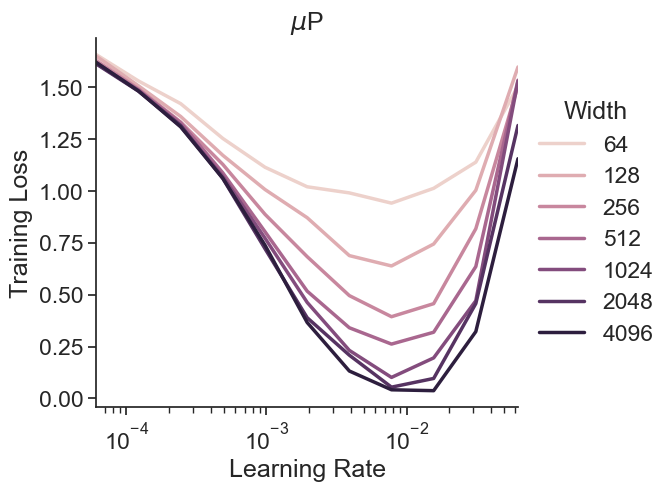

In [94]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.train.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(), legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='$\mu$P')
ax.set_xlim(min(mlp_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_mup_train"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

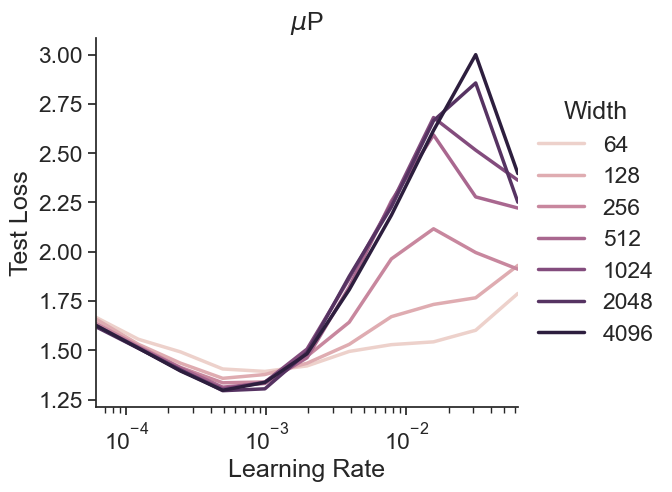

In [96]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.test.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(), legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Test Loss", title='$\mu$P')
ax.set_xlim(min(mlp_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_mup_test"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')


## MLP with SP

In [98]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == False)
    & runs_df['config.mlp_config.hidden_sizes']
    & (runs_df['config.mlp_config.add_bias'] == True)
    # & (runs_df["config.mlp_config.paper_init"].isna() | (runs_df["config.mlp_config.paper_init"] == False))
    & ((runs_df["config.mlp_config.paper_init"] == False))
    & (runs_df["summary.train.loss"] != "NaN")
    & (runs_df["config.optimization.optimizer_kwargs.momentum"] == 0.9)
    # Created before 22nd of March
    & (runs_df["created_at"] <= datetime(2023, 3, 22))
]
mlp_runs_df = mlp_runs_df[
    # Only include runs with 2 hidden layers
    (mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
mlp_runs_df = mlp_runs_df[mlp_runs_df['summary.train.loss'] != 'NaN']
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

# assert mlp_runs_df.duplicated(subset=["config.optimization.lr", "width"]).sum() == 0
mlp_runs_df = mlp_runs_df.sort_values(by=["config.optimization.lr", "width"])

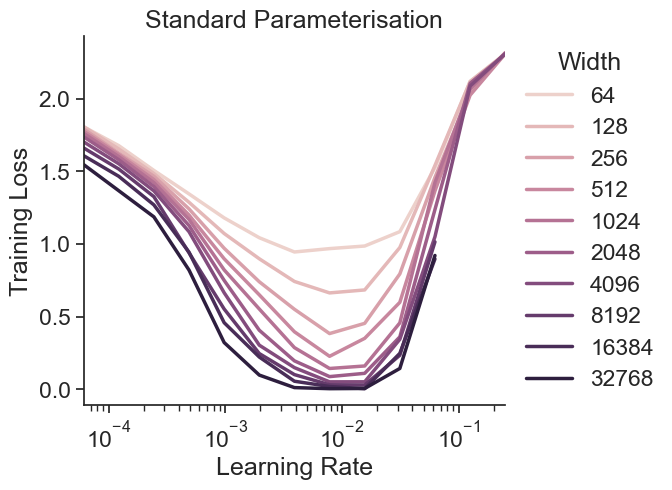

In [100]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.train.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(),legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='Standard Parameterisation')
ax.set_xlim(min(mlp_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_sp_train"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

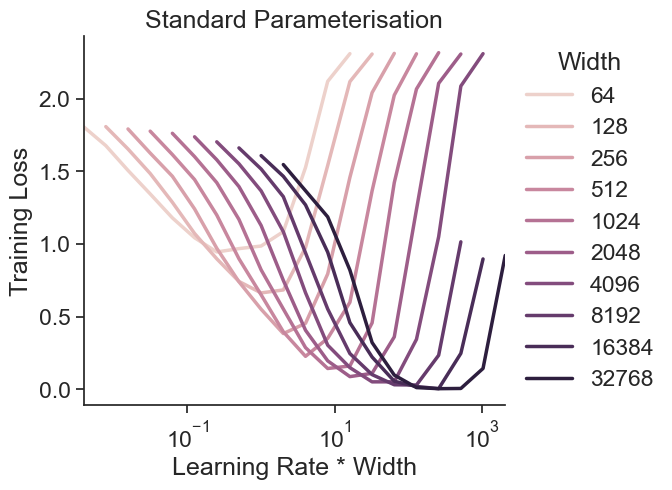

In [101]:
# Scale learning rate by width
mlp_runs_df["lr_by_width"] = mlp_runs_df["config.optimization.lr"] * mlp_runs_df["width"]

ax = sns.lineplot(data=mlp_runs_df, x='lr_by_width', y='summary.train.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(),legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate * Width", ylabel="Training Loss", title='Standard Parameterisation')
ax.set_xlim(min(mlp_runs_df["lr_by_width"]), max(mlp_runs_df["lr_by_width"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_sp_train__lr_by_width"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

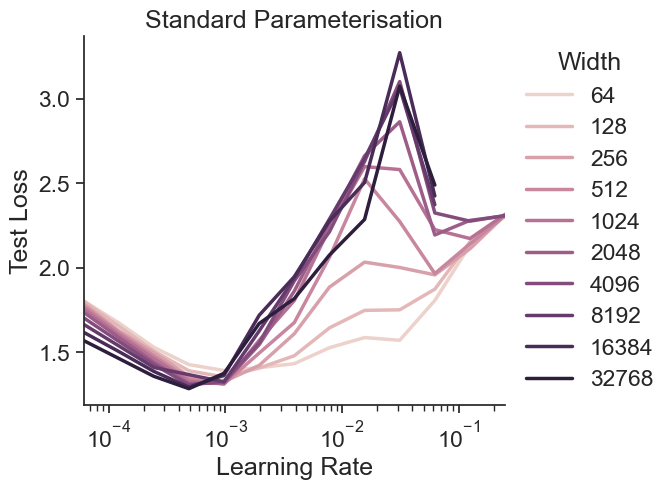

In [102]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.test.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(),legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Test Loss", title='Standard Parameterisation')
ax.set_xlim(min(mlp_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_sp_test"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

# MLP Experiments (tuned learning rates)

## muP

In [203]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == False)
    & runs_df['config.mlp_config.hidden_sizes']
    & (runs_df['config.mlp_config.add_bias'] == True)
    # & (runs_df["config.mlp_config.paper_init"].isna() | (runs_df["config.mlp_config.paper_init"] == False))
    # & (runs_df["summary.train.loss"] != "NaN")
    # Created after 22nd of March
    & (runs_df["created_at"] >= datetime(2023, 3, 22))
    # global_lr specified
    & (runs_df["config.optimization.global_lr"] != "NaN")
]
mlp_runs_df = mlp_runs_df[
    # Only include runs with 2 hidden layers
    (mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
# mlp_runs_df['config.optimization.lr_log2'] = np.log2(mlp_runs_df['config.optimization.lr'])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

In [213]:
# TODO remove, just investigating the data and configs
# mlp_runs_df["config.initialisation.init_scales_per_param.hidden_layer0.weight"]
# mlp_runs_df[["name", "summary.train.loss"]]
mlp_runs_df[mlp_runs_df["config.initialisation.init_scales_per_param.hidden_layer0.weight"].isna()]
# mlp_runs_df["config.initialisation.init_scales_per_param.hidden_layer0.weight"].isna()
# mlp_runs_df[[column for column in mlp_runs_df.columns if "initialisation" in column]]
# mlp_runs_df["config.initialisation.init_scales_per_param.output_layer.weight"]
mlp_runs_df["config.mlp_config.paper_init"]

0     False
1     False
2     False
3     False
4     False
      ...  
88    False
89    False
90    False
91    False
92    False
Name: config.mlp_config.paper_init, Length: 71, dtype: object

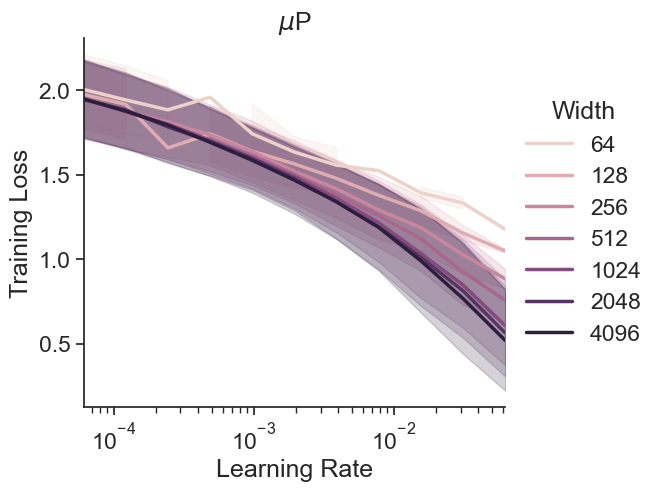

In [191]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.global_lr', y='summary.train.loss', hue='width', hue_norm=matplotlib.colors.LogNorm(),legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='Standard Parameterisation')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='$\mu$P')
ax.set_xlim(min(mlp_runs_df["config.optimization.global_lr"]), max(mlp_runs_df["config.optimization.global_lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "mlp_mup_tuned_lr_train"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

## SP (MLP with tuned LRs)

# Transformer WikiText Experiments (no hyperparam tuning)

## Transformer with muP

In [114]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.use_mu_param'] == True)
    # Created before 22nd of March
    & (runs_df["created_at"] <= datetime(2023, 3, 22))
]
# Remove NaN results
transformer_runs_df = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
# Add a "width" column to the dataframe.
# transformer_runs_df.loc[:, 'width'] = transformer_runs_df['config.transformer_config.d_model'].copy()

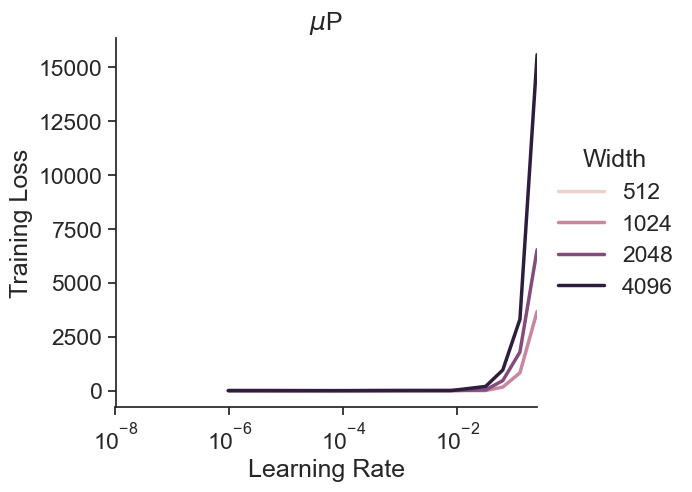

In [153]:
ax = sns.lineplot(data=transformer_runs_df, x='config.optimization.lr', y='summary.train.loss', hue='config.transformer_config.d_model', hue_norm=matplotlib.colors.LogNorm(), legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='$\mu$P')
# ax.set_xlim(min(transformer_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
# Adjust xlim because we did too many experiments with small learning rates
ax.set_xlim(1e-8, max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "transformer_mup_train"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

### Transformer with SP

In [154]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.use_mu_param'] == False)
    # Created before 22nd of March
    & (runs_df["created_at"] <= datetime(2023, 3, 22))
]
# Remove NaN results
transformer_runs_df = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']

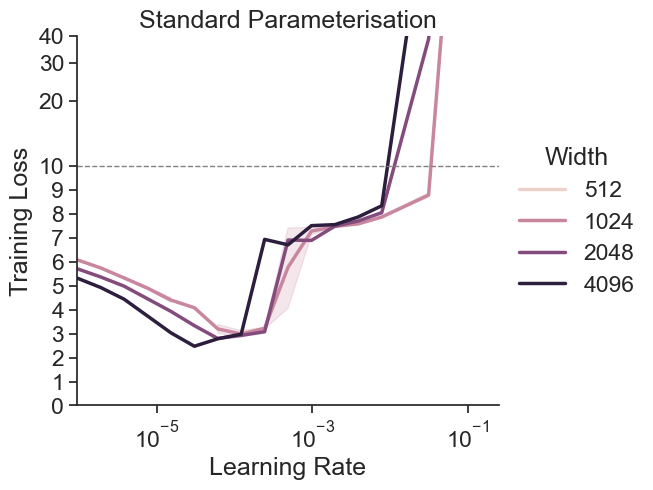

In [155]:
ax = sns.lineplot(data=transformer_runs_df, x='config.optimization.lr', y='summary.train.loss', hue='config.transformer_config.d_model', hue_norm=matplotlib.colors.LogNorm(), legend="full")
ax.set_xscale('log')
ax.set(xlabel="Learning Rate", ylabel="Training Loss", title='Standard Parameterisation')
ax.set_xlim(min(transformer_runs_df["config.optimization.lr"]), max(mlp_runs_df["config.optimization.lr"]))
ax.set_yscale('symlog', linthresh=10)
ax.set_yticks([i for i in range(10)] + [(i+1) * 10 for i in range(10)] + [(i+1) * 100 for i in range(10)])
ax.set_yticklabels([i for i in range(10)] + [(i+1) * 10 for i in range(9)] + [100] + [None for i in range(9)] + [1000])
ax.set_ylim(0, 40)
ax.axhline(10, linestyle='--', linewidth=1.0, color='gray')

# Adjust xlim because we did too many experiments with small learning rates
# ax.set_xlim(1e-8, max(mlp_runs_df["config.optimization.lr"]))
sns.despine(ax=ax)
width_legend_on_side(ax)
fig = ax.get_figure()
filename = "transformer_sp_train"
fig.savefig(f"figures/{filename}.pdf", bbox_inches='tight')
fig.savefig(f"figures/{filename}.png", bbox_inches='tight')

# Transformer with depth (no hyper tuning)

## muP

In [157]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.transformer_config.d_model'] == 1024)
    & (runs_df['config.use_mu_param'] == True)
    # Created before 22nd of March
    & (runs_df["created_at"] <= datetime(2023, 3, 22))
]

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/717312588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


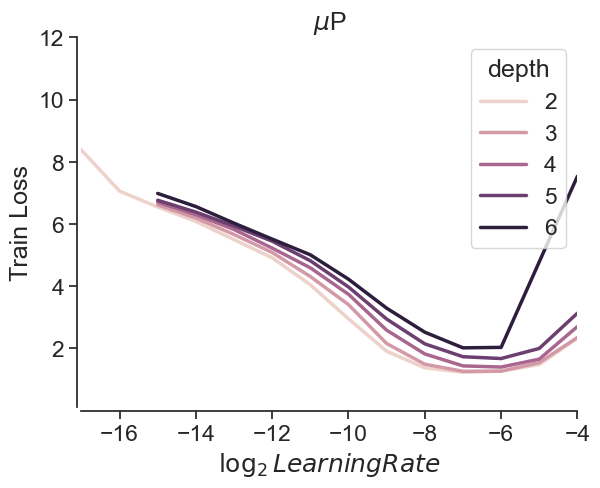

In [238]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.nlayers', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('depth')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Train Loss", title='$\mu$P')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_train_depth.png" ,bbox_inches='tight')

## Transformer with depth SP

In [239]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.transformer_config.d_model'] == 1024)
    & (runs_df['config.use_mu_param'] == False)
]

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/3950238396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


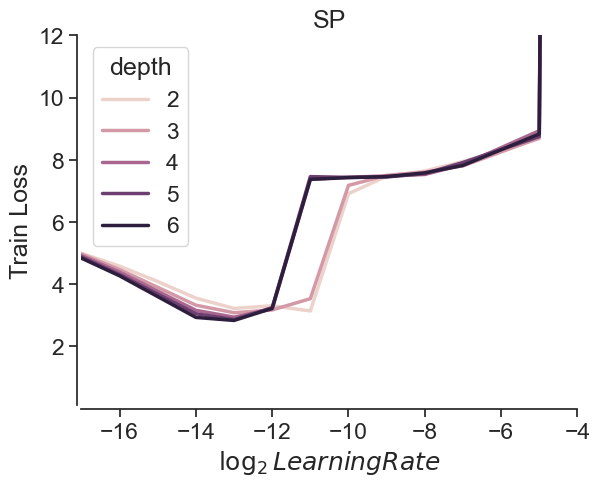

In [241]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.nlayers', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('depth')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Train Loss", title='SP')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_train_depth.png" ,bbox_inches='tight')